In [1]:
%reset -f
%pylab inline
pylab.rcParams['figure.figsize'] = (15,12) # setting default figure size
pylab.style.use('ggplot') # setting style

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import pandas as pd
from StatArb.backtest_module import Backtest
import scipy.stats as scs
from numba import jit
import matplotlib.pyplot as plt

import pylab
import pickle

import multiprocessing
from joblib import Parallel, delayed
from tqdm import tqdm
num_cores = multiprocessing.cpu_count() - 2

In [3]:
w_dir = 'S:\\Github\\MyProjects\\MLStuff\\StatArb\\strat_files\\'
ret_df = pd.read_pickle('S:\\Github\\MyProjects\\MLStuff\\StatArb\\ret_df.pkl')
ret_df.drop(columns=['start', 'ending'], inplace=True)
ret_df = ret_df.pivot_table(values='ret', index='date', columns='permno')

In [4]:
start_date = '1960/01'
train_lkbk = int(252 * 5)
min_periods = int(252 * 3)
test_lkbk = int(252 / 2)
hr_lkbk = int(252)
spread_lkbk = int(21 * 3)
# t_0 = 9954
tau = 13860
ret_df = ret_df[start_date:].copy()

In [7]:
def run_stat_arb(t_0, dump=True):
    
    global ret_df
    df = ret_df.iloc[t_0:(t_0 + train_lkbk + test_lkbk)].dropna(axis=1, how='all').copy()

    dt = df.index[0].strftime('%Y_%m_%d')
    print('Current Window: {}'.format(dt))

    test_full_ids = df.iloc[train_lkbk:].dropna(axis=1, how='any').columns
    min_miss_train_ids = df.iloc[:train_lkbk][::-1].iloc[:min_periods].isnull().sum()
    train_full_ids = min_miss_train_ids.index[min_miss_train_ids == 0]
    asset_ids = train_full_ids.intersection(test_full_ids)
    df = df[asset_ids]

    print('Setting up Backtest...')
    bt = Backtest(df, 
                  train_lkbk=int(252*5), test_lkbk=int(252/2),
                  min_periods=int(252*3), opt_k=5,
                  hr_lkbk=int(252), spread_lkbk=int(21*3),
                  signal_lag = 3, corr_thresh=0.10,
                  hr_method='ols', cv_splits=4)

    print('Selecting Pairs for Trading...')
    bt.get_pairs()

    print('Running Pairs in Trading Period...')
    bt.get_pairs_strat()
    if dump:
        filename = 'stat_arb_v1_{}.pkl'.format(dt)
        with open(w_dir + filename, 'wb') as handle:
            pickle.dump(bt.strat_dict, 
                        handle,
                        protocol = pickle.HIGHEST_PROTOCOL)
    else: return bt

In [8]:
for t_0 in range(0, tau+1, test_lkbk): run_stat_arb(t_0, dump=True)

Current Window: 2014_07_28
Setting up Backtest...
Selecting Pairs for Trading...
Pair Selection Process Complete...
Running Pairs in Trading Period...
Iterating through Pairs...
Current Window: 2015_01_27
Setting up Backtest...
Selecting Pairs for Trading...
Pair Selection Process Complete...
Running Pairs in Trading Period...
Iterating through Pairs...


In [68]:
bt_df = pd.concat(
    [
        pd.DataFrame(pd.read_pickle(w_dir+'stat_arb_{}.pkl'.format(ret_df.index[ix].strftime('%Y_%m_%d')))).\
            apply(lambda x: np.log(1+x)).\
        mean(axis=1) for ix in range(0,tau+1, test_lkbk)
    ],
    axis=0).to_frame('stat_arb').apply(lambda x: 1+x).cumprod().\
        resample('M').last().pct_change()

pd.DataFrame(
    [
        bt_df.mean()*12, 
        bt_df.std()*np.sqrt(12), 
        bt_df.mean()*np.sqrt(12)/bt_df.std()
    ], 
    index=['Excess Return', 'Volatility', 'Sharpe Ratio'])

,stat_arb
Excess Return,0.025753
Volatility,0.023187
Sharpe Ratio,1.110657


Text(0.5, 1.0, 'Stat Arb ML Curve')

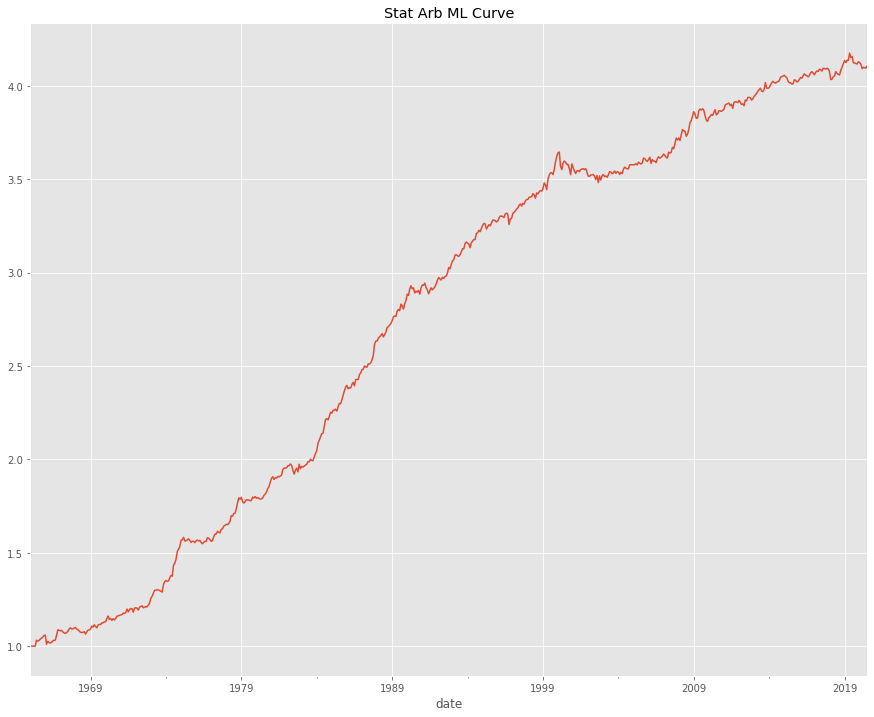

In [83]:
bt_df['curve'] = (bt_df['stat_arb']+1).cumprod()
bt_df['curve'].plot()
plt.title('Stat Arb ML Curve')

Text(0.5, 1.0, 'Stat Arb ML Underwater Curve')

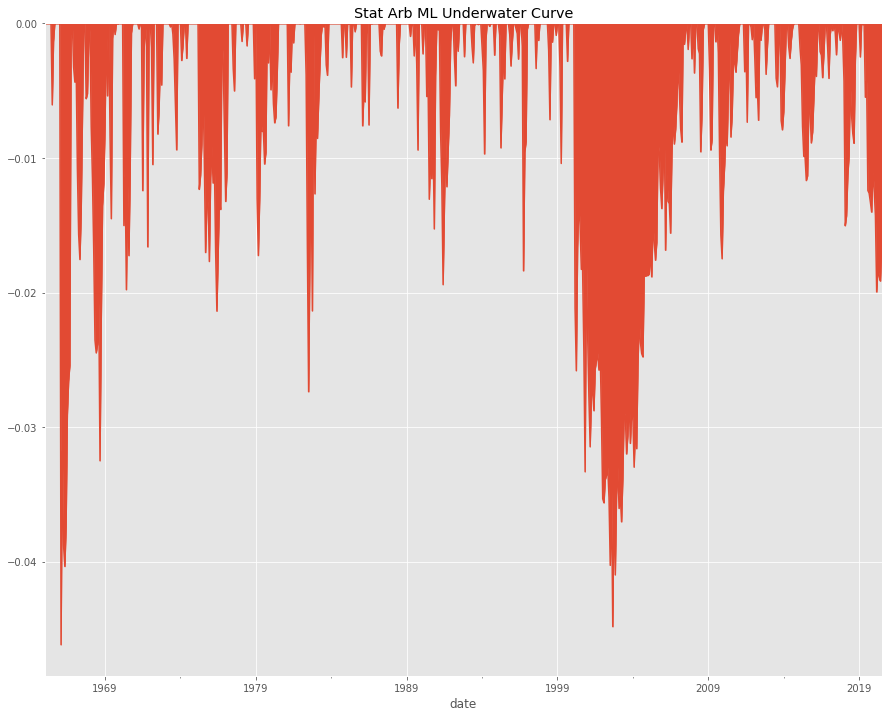

In [84]:
(bt_df['curve']/bt_df['curve'].cummax()-1).plot.area()
plt.title('Stat Arb ML Underwater Curve')

Text(0.5, 1.0, '3 Year Rolling Sharpe')

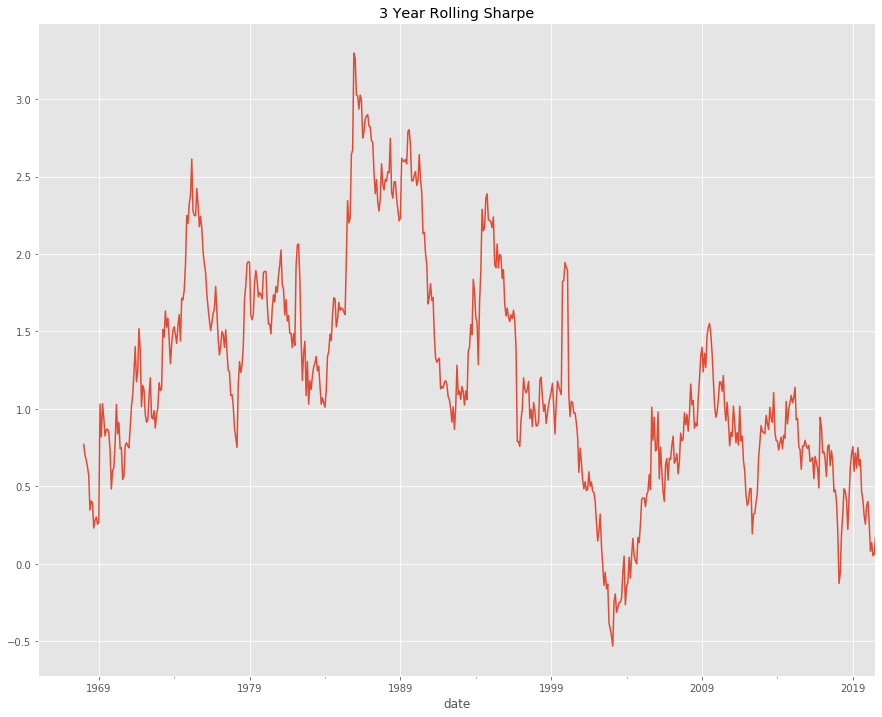

In [87]:
bt_df['stat_arb'].rolling(36).apply(lambda x: x.mean()*sqrt(12)/x.std()).plot()
plt.title('3 Year Rolling Sharpe')

In [ ]:
# Parallel(n_jobs=num_cores)(delayed(run_stat_arb)(i) for i in tqdm(range(9450, tau+1, test_lkbk)))

100%|███████████████████████████████████████████████████████████████████████████████| 36/36 [1:06:43<00:00, 111.21s/it]
